In [1]:
!nvidia-smi

Wed May  5 15:43:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd ../content/drive/MyDrive/github/Pokemon-GAN

/content/drive/MyDrive/github/Pokemon-GAN


In [5]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Basic Module

## Pixel Normalization
$$ output = \frac{x}{\sqrt{\frac{1}{x_{ChannelSize}}\sum x_{channel}^2} + \epsilon}$$

In [6]:
# RMS
class PixelNorm(nn.Module):
    def forward(self, x):
        eps = 1e-7
        mean = torch.mean(x**2, dim=1, keepdims=True)
        return x / (torch.sqrt(mean)+eps)

## Equalized Learning Rate
$$output = x \times (\frac{gain}{x_{ChannelSize}})^{0.2}$$

In [7]:
# Normalize features with channel size
class WeightScale(nn.Module):
    def forward(self, x, gain=2):
        scale = (gain/x.shape[1])**0.5
        return x * scale

## Minibatch std
$$Channel(R,G,B)\;\; -> \;Channel(R,G,B,MBS)$$

In [8]:
# Cal Standard deviation to diversity
class MiniBatchStd(nn.Module):
    def forward(self, x):
        std = torch.std(x, dim=0, keepdim=True)
        mean = torch.mean(std, dim=(1,2,3), keepdim=True)
        n,c,h,w = x.shape
        mean = torch.ones(n,1,h,w, dtype=x.dtype, device=x.device)*mean
        return torch.cat((x,mean), dim=1)

## Conv2d Module

In [9]:
# All in one conv2d
class Conv2d(nn.Module):
    def __init__(self, inch, outch, kernel_size, padding=0):
        super().__init__()
        self.layers = nn.Sequential(
            WeightScale(),
            nn.ReflectionPad2d(padding),
            nn.Conv2d(inch, outch, kernel_size, padding=0),
            PixelNorm(),
            )
        nn.init.kaiming_normal_(self.layers[2].weight)

    def forward(self, x):
        return self.layers(x)

## Conv Module G

In [10]:
# First layer difference
class ConvModuleG(nn.Module):
    def __init__(self, out_size, inch, outch, first=False):
        super().__init__()

        if first:
            layers = [
                Conv2d(inch, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
                Conv2d(outch, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
            ]

        else:
            layers = [
                nn.Upsample((out_size, out_size), mode='nearest'),
                Conv2d(inch, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
                Conv2d(outch, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
            ]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

## ConvModule D

In [11]:
# Final layer difference
class ConvModuleD(nn.Module):
    def __init__(self, out_size, inch, outch, final=False):
        super().__init__()

        if final:
            layers = [
                MiniBatchStd(), # final block only
                Conv2d(inch+1, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
                Conv2d(outch, outch, 4, padding=0), 
                nn.LeakyReLU(0.2, inplace=False),
                nn.Conv2d(outch, 1, 1, padding=0), 
            ]
        else:
            layers = [
                Conv2d(inch, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
                Conv2d(outch, outch, 3, padding=1),
                nn.LeakyReLU(0.2, inplace=False),
                nn.AdaptiveAvgPool2d((out_size, out_size)),
            ]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Generator

In [48]:
# Flexible layer Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # conv modules & toRGBs
        scale = 1
        inchs  = np.array([1024,512,256,128,64,32,16], dtype=np.uint32)*scale
        outchs = np.array([512,256,128, 64,32,16, 8], dtype=np.uint32)*scale
        sizes = np.array([4,8,16,32,64,128,256], dtype=np.uint32)
        firsts = np.array([True, False, False, False, False, False, False], dtype=np.bool)
        blocks, toRGBs = [], []
        for s, inch, outch, first in zip(sizes, inchs, outchs, firsts):
            blocks.append(ConvModuleG(s, inch, outch, first))
            toRGBs.append(nn.Conv2d(outch, 3, 1, padding=0))

        self.blocks = nn.ModuleList(blocks)
        self.toRGBs = nn.ModuleList(toRGBs)

    def forward(self, x, res, eps=1e-7):
        # to image
        n,c = x.shape
        x = x.reshape(n,c//16,4,4)

        # for the highest resolution
        res = min(res, len(self.blocks))

        # get integer by floor
        nlayer = max(int(res-eps), 0)
        for i in range(nlayer):
            x = self.blocks[i](x)

        # high resolution
        x_big = self.blocks[nlayer](x)
        dst_big = self.toRGBs[nlayer](x_big)

        if nlayer==0:
            x = dst_big
        else:
            # low resolution
            x_sml = F.interpolate(x, x_big.shape[2:4], mode='nearest')
            dst_sml = self.toRGBs[nlayer-1](x_sml)
            alpha = res - int(res-eps)
            x = (1-alpha)*dst_sml + alpha*dst_big

        #return x, n, res
        return torch.sigmoid(x)

# Discriminator

In [49]:
# Flexible layer Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.minbatch_std = MiniBatchStd()

        # conv modules & toRGBs
        scale = 1
        inchs  = np.array([512,256,128, 64,32,16, 8], dtype=np.uint32)*scale
        outchs = np.array([1024,512,256,128,64,32,16], dtype=np.uint32)*scale
        sizes = np.array([1,4,8,16,32,64,128], dtype=np.uint32)
        finals = np.array([True, False, False, False, False, False, False], dtype=np.bool)
        blocks, fromRGBs = [], []
        for s, inch, outch, final in zip(sizes, inchs, outchs, finals):
            fromRGBs.append(nn.Conv2d(3, inch, 1, padding=0))
            blocks.append(ConvModuleD(s, inch, outch, final=final))

        self.fromRGBs = nn.ModuleList(fromRGBs)
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x, res):
        # for the highest resolution
        res = min(res, len(self.blocks))

        # get integer by floor
        eps = 1e-7
        n = max(int(res-eps), 0)

        # high resolution
        x_big = self.fromRGBs[n](x)
        x_big = self.blocks[n](x_big)

        if n==0:
            x = x_big
        else:
            # low resolution
            x_sml = F.adaptive_avg_pool2d(x, x_big.shape[2:4])
            x_sml = self.fromRGBs[n-1](x_sml)
            alpha = res - int(res-eps)
            x = (1-alpha)*x_sml + alpha*x_big

        for i in range(n):
            x = self.blocks[n-1-i](x)

        return x

# Gradient Penalty

In [50]:
def gradient_penalty(netD, real, fake, res, batch_size, gamma=1):
    device = real.device
    alpha = torch.rand(batch_size, 1, 1, 1, requires_grad=True).to(device)
    x = alpha*real + (1-alpha)*fake
    d_ = netD.forward(x, res)
    g = torch.autograd.grad(outputs=d_, inputs=x,
                            grad_outputs=torch.ones(d_.shape).to(device),
                            create_graph=True, retain_graph=True,only_inputs=True)[0]
    g = g.reshape(batch_size, -1)
    return ((g.norm(2,dim=1)/gamma-1.0)**2).mean()

# Data Loader

In [51]:
def make_datapath_list():

    train_img_list = list()

    for i in range(898):
        index = i+1
        if index//10 == 0:
            index_str = f"00{index}"
        elif index/10 < 10:
            index_str = f"0{index}"
        else:
            index_str = str(index)
        img_path = f"./Pokemon_zukan/img{index_str}.png"
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():

    def __init__(self, size):
        self.data_transform = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.ToTensor(),
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)
        return img_transformed

# Training!

In [52]:
def train_model(model_name=None):

    if model_name != None:
        if not os.path.isdir(f"./saved_model/{model_name}"):
          os.makedirs(f"./saved_model/{model_name}")
          os.makedirs(f"./saved_model/{model_name}/CPU/Generator")
          os.makedirs(f"./saved_model/{model_name}/CPU/Discriminator")
          os.makedirs(f"./saved_model/{model_name}/GPU/Generator")
          os.makedirs(f"./saved_model/{model_name}/GPU/Discriminator")
  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"device:{device}")
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG_mavg = Generator().to(device) # moving average
    optG = torch.optim.Adam(netG.parameters(), lr=0.0005, betas=(0.0, 0.99))
    optD = torch.optim.Adam(netD.parameters(), lr=0.0005, betas=(0.0, 0.99))
    criterion = torch.nn.BCELoss()

    train_img_list=make_datapath_list()

    size = 256
    train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(size))

    batch_size = 16

    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

    epochs = 1010
    losses = []
    res_step = 5000
    j = 0

    z0 = torch.randn(16, 512*16).to(device)
    z0 = torch.clamp(z0, -1.,1.)
    for epoch in range(epochs):
        t_epoch_start = time.time()
        if j==res_step*7.5:
            optG.param_groups[0]['lr'] = 0.0001
            optD.param_groups[0]['lr'] = 0.0001

        for i, x in enumerate(train_loader):
            x = x.to(device)
            res = j/res_step
            mini_batch_size = x.size()[0]

            z = torch.randn(mini_batch_size, 1024*16).to(x.device)
            x_ = netG.forward(z, res)
            d_ = netD.forward(x_, res) # fake
            lossG = -d_.mean()

            optG.zero_grad()
            lossG.backward()
            optG.step()

            momentum = 0.995 # remain momentum
            alpha = min(1.0-(1/(j+1)), momentum)
            for p_mavg, p in zip(netG_mavg.parameters(), netG.parameters()):
                p_mavg.data = alpha*p_mavg.data + (1.0-alpha)*p.data
            
            z = torch.randn(x.shape[0], 1024*16).to(device)
            x_fake = netG.forward(z, res)
            x = F.adaptive_avg_pool2d(x, x_fake.shape[2:4])
            d_real = netD.forward(x, res)
            d_fake = netD.forward(x_fake, res)
            loss_real = -d_real.mean()
            loss_fake = d_fake.mean()
            loss_gp = gradient_penalty(netD, x.data, x_fake.data, res, x.shape[0])
            loss_drift = (d_real**2).mean()

            beta_gp = 10.0
            beta_drift = 0.001
            lossD = loss_real + loss_fake + beta_gp*loss_gp + beta_drift*loss_drift

            optD.zero_grad()
            lossD.backward()
            optD.step()

            print(f"epoch:{epoch} {i} {j} lossG:{lossG.item():.10f} lossD:{lossD.item():.10f}")

            losses.append([lossG.item(), lossD.item()])
            j+=1
            #save model
            if model_name != None and epoch%50 == 0:
              model_path =  f"./saved_model/{model_name}"
              file_name = f"{epoch}.pth"
              torch.save(netG.state_dict(), f"{model_path}/GPU/Generator/{file_name}")
              torch.save(netD.state_dict(), f"{model_path}/GPU/Discriminator/{file_name}")
              torch.save(netG.to('cpu').state_dict(), f"{model_path}/CPU/Generator/{file_name}")
              torch.save(netD.to('cpu').state_dict(), f"{model_path}/CPU/Discriminator/{file_name}")
              netG.to(device)
              netD.to(device)

            if j >= res_step*8:
                break
        t_epoch_finish = time.time()
        print(f"epoch:{epoch} time: {t_epoch_finish - t_epoch_start:.4f}")
        if j >= res_step*8:
            break
    return netG, netD, losses

In [53]:
G_update, D_update, losses = train_model(model_name="1024_256PGGAN")

ストリーミング出力は最後の 5000 行に切り捨てられました。
epoch:615 32 35087 lossG:3.8632056713 lossD:-6.8993911743
epoch:615 33 35088 lossG:6.5536289215 lossD:-4.5209007263
epoch:615 34 35089 lossG:1.9130837917 lossD:-10.5377321243
epoch:615 35 35090 lossG:6.6238532066 lossD:-4.5105929375
epoch:615 36 35091 lossG:1.8021949530 lossD:-7.4572930336
epoch:615 37 35092 lossG:3.9342679977 lossD:-6.4801054001
epoch:615 38 35093 lossG:1.2763924599 lossD:-14.1030273438
epoch:615 39 35094 lossG:6.0391416550 lossD:-1.3177881241
epoch:615 40 35095 lossG:11.7859373093 lossD:-12.0280466080
epoch:615 41 35096 lossG:8.7201395035 lossD:-12.8631172180
epoch:615 42 35097 lossG:12.3570995331 lossD:-14.0415802002
epoch:615 43 35098 lossG:18.2751579285 lossD:-23.8037261963
epoch:615 44 35099 lossG:15.5795793533 lossD:-9.8535118103
epoch:615 45 35100 lossG:20.8572483063 lossD:-20.0529518127
epoch:615 46 35101 lossG:10.7056331635 lossD:-2.7514855862
epoch:615 47 35102 lossG:14.1374197006 lossD:-11.0945949554
epoch:615 48 35103 lossG:

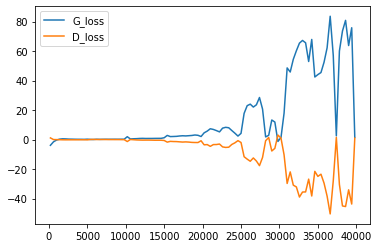

In [54]:
np_losses = np.array(losses)
niter = np_losses.shape[0]//100*100
x_iter = np.arange(100)*(niter//100) + niter//200
plt.plot(x_iter, np_losses[:niter,0].reshape(100,-1).mean(1), label="G_loss")
plt.plot(x_iter, np_losses[:niter,1].reshape(100,-1).mean(1), label="D_loss")
plt.legend()
plt.savefig("out/1024_256PGGAN_losses_graph.png")

cuda:0


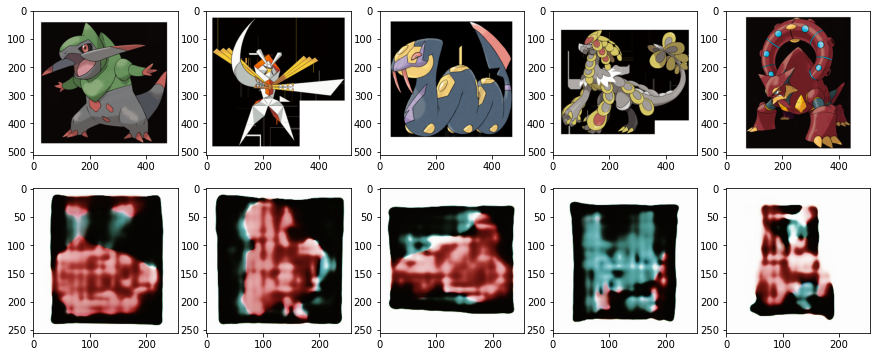

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16
feature_dim = 1024
fixed_z = torch.randn(batch_size, feature_dim*16)
G_update = Generator()
model_path = "./saved_model/1024_256PGGAN/CPU/Generator/700.pth"
G_update.load_state_dict(torch.load(model_path))
G_update.eval()
fake_images = G_update(fixed_z.to('cpu'),7.5)

train_img_list=make_datapath_list()
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(512))
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

batch_iterator = iter(train_loader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15,6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    img = transforms.functional.to_pil_image(images[i])
    plt.imshow(img)

    plt.subplot(2, 5, 5+i+1)
    fake_img = transforms.functional.to_pil_image(fake_images[i])
    plt.imshow(fake_img)
    # fake_img.save(f"./out/image_generated/1024_256PGGAN{i}.png",quality=95)